# TP6 ALTEGRAD - LACOMBE Yoach



In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd 'My Drive'/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive


In [ ]:
PATH_KARATE_EDGE_LIST = './dataset_ALTEGRAD/karate.edgelist'
PATH_KARATE_LABELS = './dataset_ALTEGRAD/karate_labels.txt'


## Autoencoders

In [ ]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import scipy.sparse as sp
import numpy as np
import torch
import torch.nn as nn

def normalize_adjacency(A):
    ############## Task 1
    
    ##################
    # your code here #
    ##################
    diag = A.sum(axis = 1)
    d = sp.identity(A.shape[0])
    d.setdiag(1/diag[0])

    A_normalized = d@(A + sp.identity(A.shape[0]))

    return A_normalized


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def loss_function(z, adj, device):
    mse_loss = nn.MSELoss()

    ############## Task 3
    
    ##################
    # your code here #
    ##################
    indices = adj._indices()
    #indices -> (2,nb_elements)
    
    adj_hat = torch.sigmoid(z@(z.T))

    zero_indices = torch.zeros_like(indices)
    cpt = 0
    i = 0
    while cpt < indices.shape[1]:
      a,b = np.random.randint(0, len(adj_hat), size = 2)
      if adj[a,b] == 0:
        zero_indices[0, i] = a
        zero_indices[1, i] = b
        i+=1
        cpt +=1


    adj_hat_indices = adj_hat[indices[0,:], indices[1,:]]
    adj_hat_zeros = adj_hat[zero_indices[0,:], zero_indices[1,:]]
    adj_indices = adj._values()

    y = torch.cat([adj_indices, torch.zeros_like(adj_indices)])
    y_pred = torch.cat([adj_hat_indices, adj_hat_zeros])

    
    loss = mse_loss(y_pred, y)
    return loss


In [ ]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GAE(nn.Module):
    """GAE model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, dropout):
        super(GAE, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Task 2
    
        ##################
        # your code here #
        ##################
        h = self.relu(self.fc1(torch.mm(adj, x_in)))
        h = self.dropout(h)
        z = self.fc2(torch.mm(adj,h))

        return z


34
78
Epoch: 0001 loss_train: 0.5392 time: 0.0217s
Epoch: 0011 loss_train: 0.2761 time: 0.0235s
Epoch: 0021 loss_train: 0.3080 time: 0.0211s
Epoch: 0031 loss_train: 0.2412 time: 0.0221s
Epoch: 0041 loss_train: 0.2871 time: 0.0228s
Epoch: 0051 loss_train: 0.3489 time: 0.0249s
Epoch: 0061 loss_train: 0.2745 time: 0.0218s
Epoch: 0071 loss_train: 0.2689 time: 0.0210s
Epoch: 0081 loss_train: 0.2661 time: 0.0378s
Epoch: 0091 loss_train: 0.2962 time: 0.0256s
Epoch: 0101 loss_train: 0.2953 time: 0.0229s
Epoch: 0111 loss_train: 0.2531 time: 0.0227s
Epoch: 0121 loss_train: 0.2874 time: 0.0219s
Epoch: 0131 loss_train: 0.2926 time: 0.0224s
Epoch: 0141 loss_train: 0.2689 time: 0.0364s
Epoch: 0151 loss_train: 0.3124 time: 0.0330s
Epoch: 0161 loss_train: 0.2850 time: 0.0291s
Epoch: 0171 loss_train: 0.2691 time: 0.0235s
Epoch: 0181 loss_train: 0.3114 time: 0.0255s
Epoch: 0191 loss_train: 0.2987 time: 0.0266s


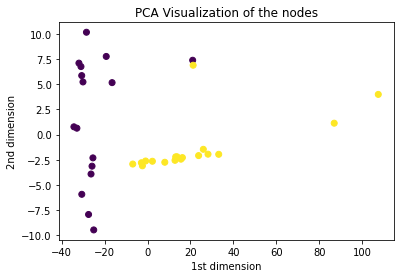

homogeneity_score 0.36833966164876614


In [ ]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score




# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
n_hidden_1 = 16
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist(PATH_KARATE_EDGE_LIST, delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

features = np.random.randn(n, 10) # Generates node features

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
adj = sparse_to_torch_sparse(adj).to(device)

# Creates the model and specifies the optimizer
model = GAE(features.shape[1], n_hidden_1, n_hidden_2, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    z = model(features, adj)
    loss = loss_function(z, adj, device)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss.item()),
              'time: {:.4f}s'.format(time.time() - t))


# Loads the class labels
class_labels = np.loadtxt(PATH_KARATE_LABELS, delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

############## Task 4
    
##################
# your code here #
##################
embeddings = z.detach().cpu().numpy()
embeddings_2d = PCA(n_components = 2).fit_transform(embeddings)

# Visualizes the nodes
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=y)
plt.title('PCA Visualization of the nodes')
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.show()

############## Task 5
    
##################
# your code here #
##################

kmeans = KMeans(n_clusters = 2)
kmeans.fit(embeddings)

print("homogeneity_score", homogeneity_score(y,kmeans.predict(embeddings)))



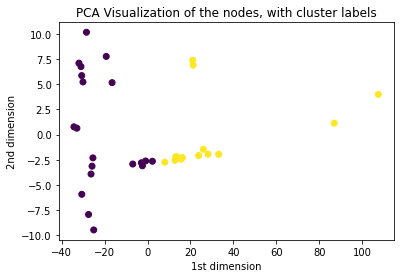

In [ ]:
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=kmeans.predict(embeddings))
plt.title('PCA Visualization of the nodes, with cluster labels')
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.show()

## GNN for Graph-Level Tasks

In [ ]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import networkx as nx
import numpy as np
import torch
from random import randint

def create_dataset():
    Gs = list()
    y = list()

    ############## Task 6
    
    ##################
    # your code here #
    ##################
    Gs = [nx.generators.random_graphs.fast_gnp_random_graph(n,0.2) for n in np.random.randint(10,21, size = 50)]
    Gs = Gs + [nx.generators.random_graphs.fast_gnp_random_graph(n,0.4) for n in np.random.randint(10,21, size = 50)]

    y = [0] * 50 + [1]*50
    return Gs, y


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


In [ ]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, n_class, device):
        super(GNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, n_class)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, idx):
        
        ############## Task 7
    
        ##################
        # your code here #
        ##################
        z0 = self.relu(self.fc1(torch.mm(adj, x_in)))
        x = self.fc2(torch.mm(adj, z0))
        #readout
        idx = idx.unsqueeze(1).repeat(1, x.size(1)).type(torch.int64)
        out = torch.zeros(int(torch.max(idx).item()+1), x.size(1)).to(self.device)
        out = out.scatter_add_(0, idx, x) 
        
        ##################
        # your code here #
        ##################
        out = self.relu(self.fc3(out))
        out = self.fc4(out)

        return F.log_softmax(out, dim=1)


In [ ]:
"""
Deep Learning on Graphs - ALTEGRAD - Jan 2022
"""

import time
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
batch_size = 8
n_hidden_1 = 16
n_hidden_2 = 32
n_hidden_3 = 32
learning_rate = 0.01

# Generates synthetic dataset
Gs, y = create_dataset()
n_class = np.unique(y).size

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

N_train = len(G_train)
N_test = len(G_test)

# Initializes model and optimizer
model = GNN(1, n_hidden_1, n_hidden_2, n_hidden_3, n_class, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    
    train_loss = 0
    correct = 0
    count = 0
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        idx_batch = list()
        y_batch = list()

        ############## Task 8
        
        ##################
        # your code here #
        ##################
        adj_batch = sp.block_diag([nx.linalg.graphmatrix.adjacency_matrix(G) for G in G_train[i: i+batch_size]])
        for j,G in enumerate(G_train[i: i+batch_size]):
          idx_batch = idx_batch + [j]*G.number_of_nodes()
        y_batch = y_train[i:i+batch_size]
        features_batch = np.ones((adj_batch.shape[0],1))



        adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch)
        y_batch = torch.Tensor(y_batch).type(torch.long)
        features_batch = torch.Tensor(features_batch)
        idx_batch = torch.Tensor(idx_batch)

        
        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)

        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
print('Optimization finished!')

# Evaluates the model
model.eval()
test_loss = 0
correct = 0
count = 0
for i in range(0, N_test, batch_size):
    adj_batch = list()
    idx_batch = list()
    y_batch = list()

    ############## Task 8
    
    ##################
    # your code here #
    ##################
    adj_batch = sp.block_diag([nx.linalg.graphmatrix.adjacency_matrix(G) for G in G_train[i: i+batch_size]])
    for j,G in enumerate(G_train[i: i+batch_size]):
      idx_batch = idx_batch + [j]*G.number_of_nodes()
    y_batch = y_train[i:i+batch_size]
    features_batch = np.ones((adj_batch.shape[0],1))



    adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch)
    y_batch = torch.Tensor(y_batch).type(torch.long)
    features_batch = torch.Tensor(features_batch)
    idx_batch = torch.Tensor(idx_batch)

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))


Epoch: 0001 loss_train: 5.9328 acc_train: 0.4333 time: 0.1193s
Epoch: 0011 loss_train: 0.2630 acc_train: 0.8667 time: 0.1166s
Epoch: 0021 loss_train: 0.2634 acc_train: 0.8778 time: 0.1216s
Epoch: 0031 loss_train: 0.2538 acc_train: 0.8778 time: 0.0663s
Epoch: 0041 loss_train: 0.2413 acc_train: 0.8889 time: 0.0654s
Epoch: 0051 loss_train: 0.2274 acc_train: 0.8778 time: 0.0633s
Epoch: 0061 loss_train: 0.2286 acc_train: 0.8889 time: 0.0612s
Epoch: 0071 loss_train: 0.2032 acc_train: 0.9000 time: 0.0605s
Epoch: 0081 loss_train: 0.2245 acc_train: 0.8667 time: 0.0654s
Epoch: 0091 loss_train: 0.1742 acc_train: 0.9222 time: 0.0798s
Epoch: 0101 loss_train: 0.2656 acc_train: 0.8889 time: 0.0691s
Epoch: 0111 loss_train: 0.1833 acc_train: 0.9222 time: 0.0633s
Epoch: 0121 loss_train: 0.1514 acc_train: 0.9556 time: 0.0727s
Epoch: 0131 loss_train: 0.1546 acc_train: 0.9556 time: 0.0637s
Epoch: 0141 loss_train: 0.1436 acc_train: 0.9444 time: 0.0620s
Epoch: 0151 loss_train: 0.5514 acc_train: 0.8667 time: 